In [1]:
import ast
import pandas as pd 
import timeit
import numpy as np 
from statistics import mean
import prophet

# Imports

In [2]:
#Import two data-sets
starbucks_df = pd.read_csv('./Clean_Data/Starbucks_Data.csv')
airbnb_df = pd.read_csv('./Clean_Data/AirBNB_Data.csv')
#Convert List columns stored as strings to lists
starbucks_df['airbnb_distances'] = starbucks_df['airbnb_distances'].apply(ast.literal_eval)
airbnb_df['starbucks_distances'] = airbnb_df['starbucks_distances'].apply(ast.literal_eval)
#Convert Date columns to Datetime
airbnb_df['first_review'] = pd.to_datetime(airbnb_df['first_review'])
airbnb_df['last_review'] = pd.to_datetime(airbnb_df['last_review'])
#Preview to verify
display(starbucks_df.head(1))
display(starbucks_df.info())

display(airbnb_df.head(1))
display(airbnb_df.info())

,store_id,index,countryCode,ownershipTypeCode,latitude,longitude,city,countrySubdivisionCode,postalCode,distance_to_den,airbnb_distances
0,1743,3739,US,CO,39.65278,-104.928197,Denver,CO,80222,6.65,"[8.77, 8.31, 7.12, 7.1, 7.03, 5.96, 6.87, 9.22..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   store_id                303 non-null    int64  
 1   index                   303 non-null    int64  
 2   countryCode             303 non-null    object 
 3   ownershipTypeCode       303 non-null    object 
 4   latitude                303 non-null    float64
 5   longitude               303 non-null    float64
 6   city                    303 non-null    object 
 7   countrySubdivisionCode  303 non-null    object 
 8   postalCode              303 non-null    int64  
 9   distance_to_den         303 non-null    float64
 10  airbnb_distances        303 non-null    object 
dtypes: float64(3), int64(3), object(5)
memory usage: 26.2+ KB


None

,id,description,neighborhood_overview,host_neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,bathroom_count,starbucks_distances,starbucks_review_mentions
0,360,Enjoy the famous Colorado weather and unplug i...,The cottage is located in the center of Lower ...,Highland,Highland,39.766415,-105.002098,Entire guesthouse,Entire home/apt,3,...,5.0,5.0,5.0,4.91,f,2,2.87,1.0,"[8.77, 9.04, 9.19, 7.71, 7.6, 8.33, 7.4, 9.44,...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5367 entries, 0 to 5366
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              5367 non-null   int64         
 1   description                     5367 non-null   object        
 2   neighborhood_overview           5367 non-null   object        
 3   host_neighbourhood              5367 non-null   object        
 4   neighbourhood_cleansed          5367 non-null   object        
 5   latitude                        5367 non-null   float64       
 6   longitude                       5367 non-null   float64       
 7   property_type                   5367 non-null   object        
 8   room_type                       5367 non-null   object        
 9   accommodates                    5367 non-null   int64         
 10  bathrooms_text                  5367 non-null   object        
 11  bedr

None

# Data Analytics

In [3]:
#Manually assigned distances of interest
bins = [.1, .25, .5, 1, 2, 5]
#Define a function that loops through each 'bin' (not technically correct)
#and counts starbucks within that range, then populate a column with that count
#for future plots
def airbnb_to_starbucks():
    for bin in bins:
        def nested_bin(row):
            dist_to_sb_list = row['starbucks_distances']
            sb_within_range = [x for x in dist_to_sb_list if x < bin]
            return len(sb_within_range)
        column_name = f"SB_within_{bin}_miles"
        airbnb_df[column_name] = airbnb_df.apply(nested_bin, axis=1)
# Run the function
airbnb_to_starbucks()
# Do it again for starbucks
def starbucks_to_airbnb():
    for bin in bins:
        def nested_bin(row):
            dist_to_bnb_list = row['airbnb_distances']
            bnb_within_range = [x for x in dist_to_bnb_list if x < bin]
            return len(bnb_within_range)
        column_name = f"Airbnb_within_{bin}_miles"
        starbucks_df[column_name] = starbucks_df.apply(nested_bin, axis=1)
starbucks_to_airbnb()

In [4]:
#calculate the average distance to the nearest 5 starbucks or bnbs
def mean_dist_nearest_5_sb(row):
    dist_list = row['starbucks_distances']
    dist_list.sort()
    return round(mean(dist_list[:5]),2)

def mean_dist_nearest_5_bnb(row):
    dist_list = row['airbnb_distances']
    dist_list.sort()
    return round(mean(dist_list[:5]),2)

airbnb_df['nearest_5_avg'] = airbnb_df.apply(mean_dist_nearest_5_sb, axis=1)
starbucks_df['nearest_5_avg'] = starbucks_df.apply(mean_dist_nearest_5_bnb, axis=1)

In [5]:
#Add a column for "price per occupant" 
airbnb_df['price_per_occupant'] = round(airbnb_df['price']/airbnb_df['accommodates'],2)

In [15]:
first_review_df = airbnb_df.copy()
first_review_df.dropna(how='any', inplace=True)
first_review_df.set_index('first_review',inplace=True)
first_review_df_agg = first_review_df.groupby([first_review_df.index.year, first_review_df.index.month])
first_review_df_agg = first_review_df_agg['id'].count().to_frame()
first_review_df_agg.columns = ['Total_New_Airbnbs']
first_review_df_agg['dateseries'] = pd.to_datetime(first_review_df_agg.index.get_level_values(0).astype(str)+'-'+first_review_df_agg.index.get_level_values(1).astype(str))
first_review_df_agg.set_index('dateseries',inplace=True)
first_review_df_agg.reset_index(inplace=True)
first_review_df_agg.columns = ['ds','y']
# first_review_df_agg.to_csv('./Clean_Data/DateSeries_Prophet.csv')


In [33]:
def total_bnbs(row):
    date = row['ds']
    total = first_review_df_agg.loc[first_review_df_agg['ds'] <= date]['y'].sum()
    return total

first_review_df_agg['total_airbnbs'] = first_review_df_agg.apply(total_bnbs, axis=1)

total_bnb_df = first_review_df_agg[['ds','total_airbnbs']].rename(columns={'total_airbnbs':'y'})
new_bnb_df = first_review_df_agg[['ds','y']]

16:46:07 - cmdstanpy - INFO - Chain [1] start processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\matt.dipinto\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\matt.dipinto\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\matt.dipinto\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProp

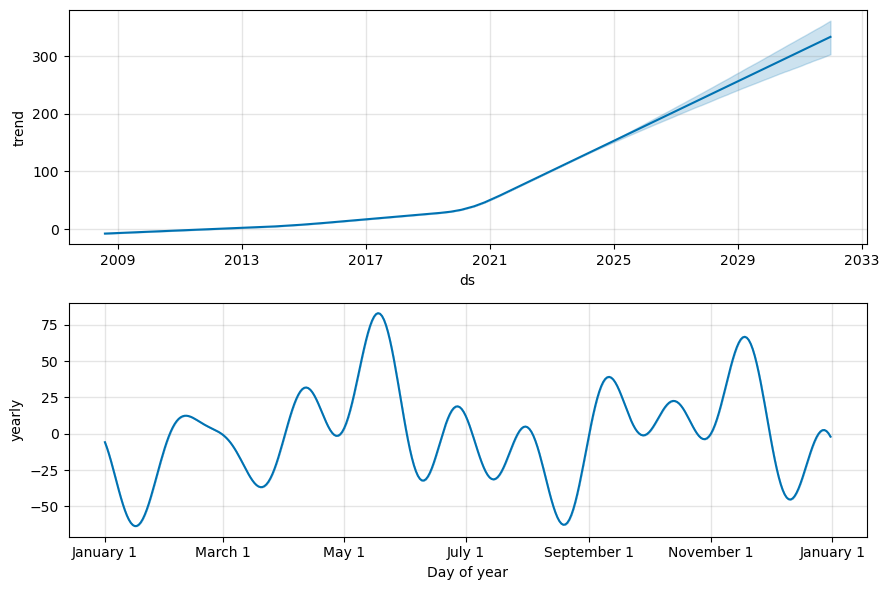

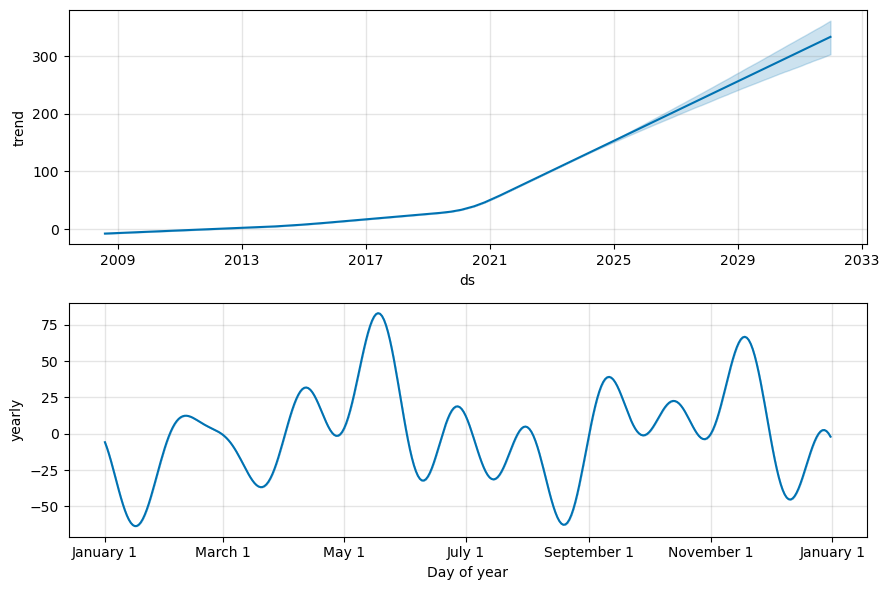

In [35]:
#model and plot for new airbnbs
m = prophet.Prophet()
m.fit(new_bnb_df)
future_df = m.make_future_dataframe(periods=100, freq='M')
forecast = m.predict(future_df)
m.plot_components(forecast)

16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\matt.dipinto\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\matt.dipinto\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\matt.dipinto\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProp

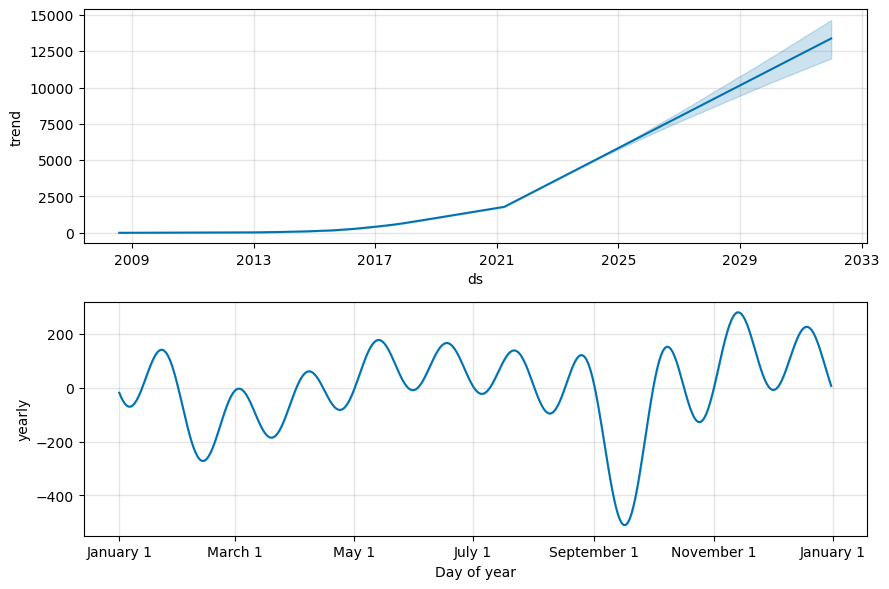

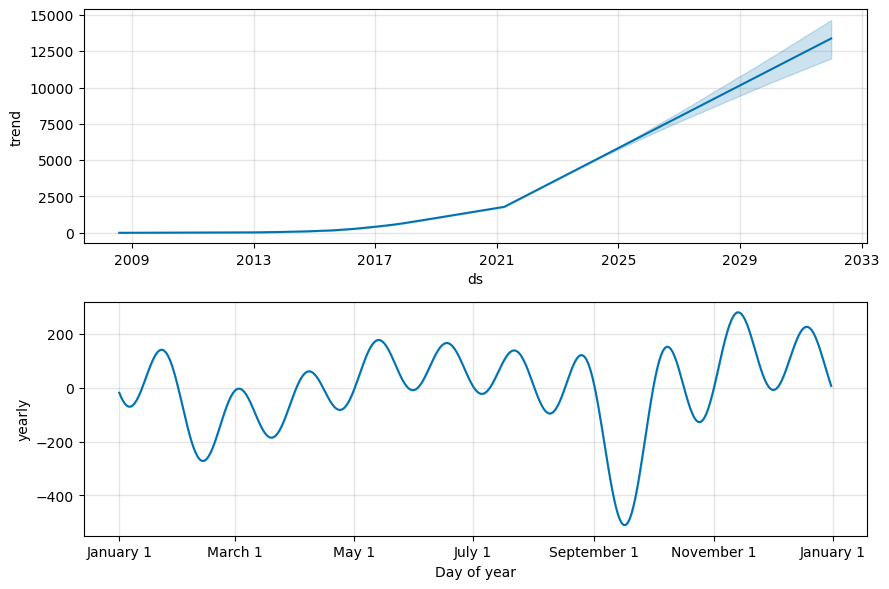

In [34]:
#model and plot for total airbnbs
m2 = prophet.Prophet()
m2.fit(total_bnb_df)
future_df2 = m2.make_future_dataframe(periods=100, freq='M')
forecast2 = m2.predict(future_df2)
m2.plot_components(forecast2)

# Visualizations

SB_within_0.5_miles
0     2457
1     1297
2      389
3       99
4       84
5       37
6       42
7        7
8       19
9       60
10      65
11      25
12       8
Name: review_scores_rating, dtype: int64

<Axes: xlabel='SB_within_0.5_miles'>

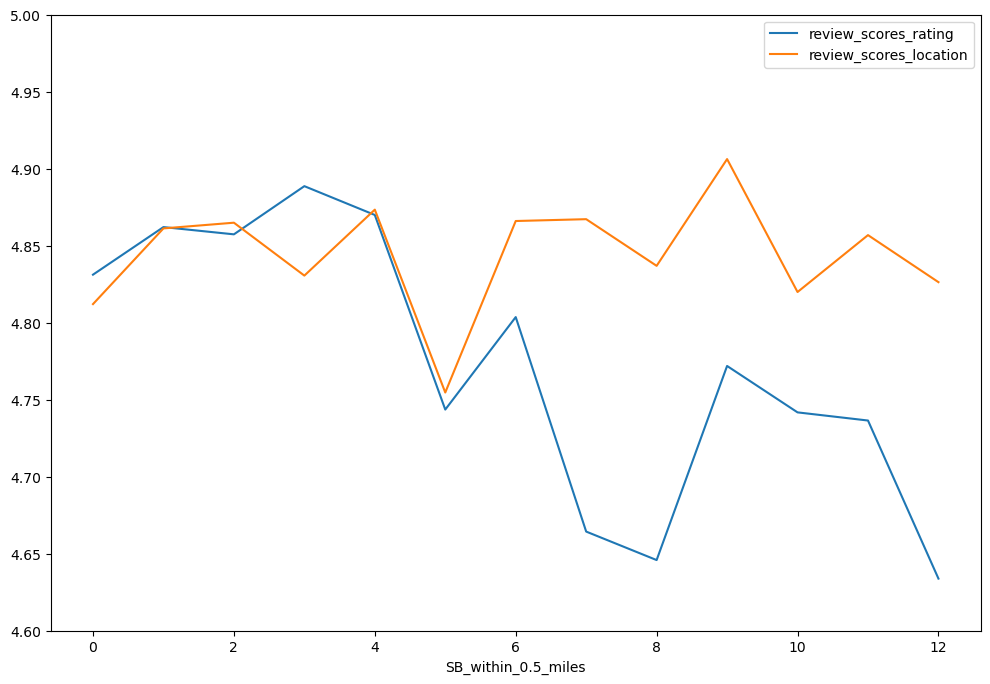

In [8]:
#Aggregate reviews by the number of SB within X miles
airbnb_df_reviewed_only = airbnb_df.loc[airbnb_df['review_scores_rating'] != -1]
aggregate_bnb_df = airbnb_df_reviewed_only.groupby(by=['SB_within_0.5_miles'])
agg_bnb_df_mean = aggregate_bnb_df[['price', 'review_scores_rating','review_scores_location']].mean()
display(aggregate_bnb_df['review_scores_rating'].count())
agg_bnb_df_mean[['review_scores_rating','review_scores_location']].plot(figsize=(12,8), ylim=(4.6,5))

<Axes: xlabel='nearest_5_avg', ylabel='review_scores_rating'>

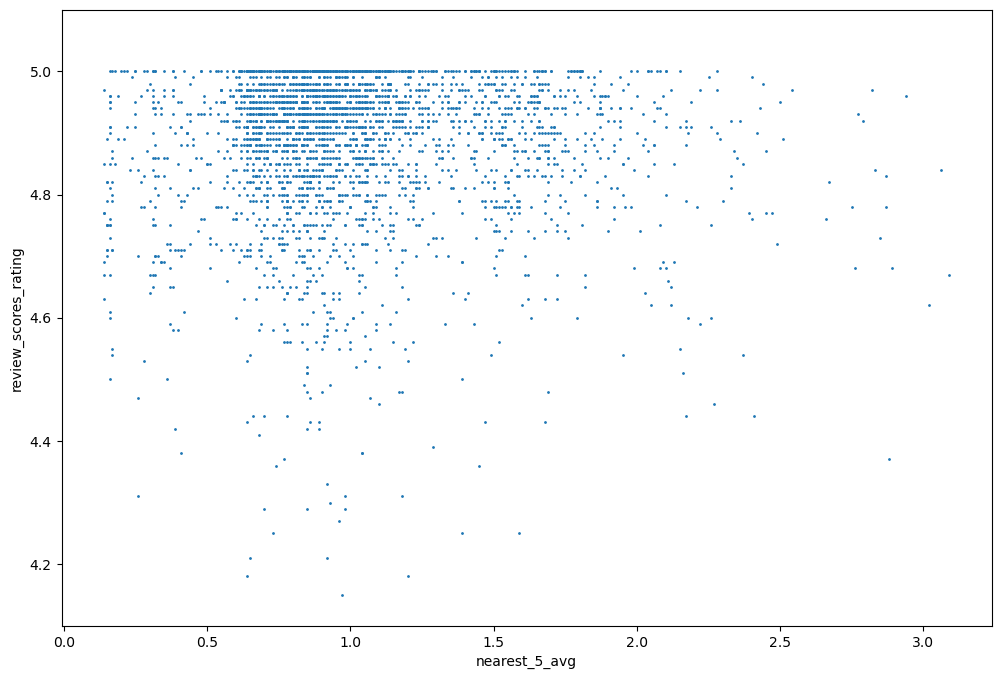

In [54]:
airbnb_df.loc[(airbnb_df['review_scores_rating'] != -1) & (airbnb_df['number_of_reviews'] > 10)]\
    .plot(x='nearest_5_avg', y='review_scores_rating', kind='scatter', ylim=(4.1, 5.1), figsize=(12,8), s=1)

C:\Users\matt.dipinto\AppData\Local\Temp\ipykernel_30488\3307781523.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_near5_airbnb = airbnb_df.loc[airbnb_df['review_scores_rating'] != -1].groupby('nearest_5_distance_bins')


Text(0, 0.5, 'Average Review')

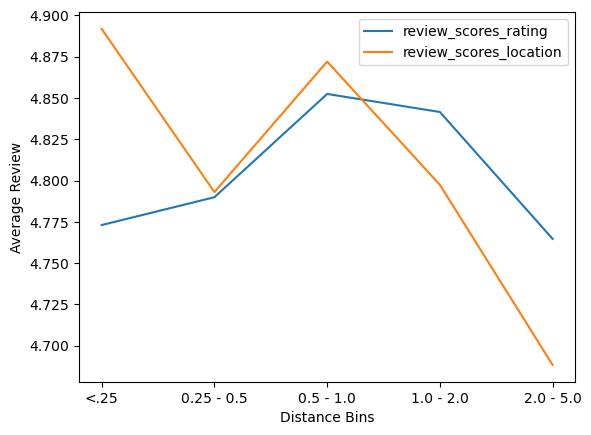

In [53]:
#actual binning of the data by nearest_5_avg
nearest_5_bins = [0, 0.25, 0.5, 1, 2, 5]
labels = [1,2,3,4,5]
airbnb_df['nearest_5_distance_bins']=pd.cut(airbnb_df['nearest_5_avg'], bins=nearest_5_bins, labels=labels)
grouped_near5_airbnb = airbnb_df.loc[airbnb_df['review_scores_rating'] != -1].groupby('nearest_5_distance_bins')
plt = grouped_near5_airbnb[['review_scores_rating', 'review_scores_location']].mean().plot()
plt.set_xticks([0,1,2,3,4])
plt.set_xticklabels(['<.25','0.25 - 0.5','0.5 - 1.0','1.0 - 2.0','2.0 - 5.0'])
plt.set_xlabel("Distance Bins")
plt.set_ylabel("Average Review")

# Testing that supported decisions while writing

In [11]:
#speed testing list comprehension vs. numpy eval:
def numpy_speed():
    data_list = starbucks_df['airbnb_distances'][0]
    numpy_array = np.array(data_list)
    nearby_distances = numpy_array[numpy_array < 1]
    nearby_distances = np.sort(nearby_distances)
    nearby_count = len(nearby_distances)
    return(nearby_count,nearby_distances)

time_taken_numpy = timeit.timeit(numpy_speed, number=5000)

def list_speed():
    data_list = starbucks_df['airbnb_distances'][0]
    keep_list = [x for x in data_list if x < 1]
    keep_list.sort()
    nearby_count = len(keep_list)
    return(nearby_count,keep_list)

time_taken_list = timeit.timeit(list_speed, number=1000)

print(f"numpy: {time_taken_numpy}")
print(f"list comprehension: {time_taken_list}")

#list comprehension was consistently ~5-10% faster

numpy: 0.7199858999811113
list comprehension: 0.14970010006800294
